# Psühhoosi prodroomi sümptomite eraldamine meditsiinitekstidest treeningandmestike loomiseks
Magistritöö (15 EAP)
Kristel Agu

Juhendajad: Sulev Reisberg (PhD), Kairit Sirts (PhD)

Käesolevas koodivihikus on toodud magistritöö tööprotsess.

### Vajalike teekide ja Word2Vec importimine

In [1]:
import sys
import re
import os
import psycopg2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from dotenv import load_dotenv
from pathlib import Path

from joblib import dump, load

#### Word2Vec mudel

Laen sisse sõnade vektorid, mille alusel hakkan leidma oma otsitavatele lausetele vektoreid. Eeltreenitud Word2Vec mudel pärineb Eesti Keeleressursside Keskuse skip-gram sõnaesinduste failist: https://entu.keeleressursid.ee/shared/7540/I7G5aC1YgdInohMJjUhi1d5e4jLdhQerZ4ikezz1JEv3B9yuJt9KiPl9lrS87Yz0 

In [2]:
wv_model = KeyedVectors.load_word2vec_format("words.sg.s100.w2v.bin", binary=True)

Tutvun Word2Vec mudeli vektoriga. Võtan näidissõnaks "veider" ja kuvan vektori:

In [3]:
word_vector = wv_model["veider"]
word_vector

array([ 0.489677  , -0.06757759,  0.4913517 ,  0.17079575, -0.34754735,
        0.03508419, -0.38074473, -0.3223883 ,  0.36341348,  0.4271472 ,
        0.00192196,  0.3290145 , -0.4747525 , -0.23610973,  0.12227923,
        0.32070485, -0.14790066, -0.16029397,  0.24335657, -0.16966338,
       -0.29142123, -0.11911654,  0.34636688, -0.30428684,  0.4361419 ,
       -0.12453059,  0.45834678,  0.21598616,  0.48576415,  0.31055462,
       -0.5950194 , -0.0661293 ,  0.04692078, -0.0953622 ,  0.29758826,
       -0.0431558 ,  0.25921   , -0.07302137, -0.10943634, -0.29749694,
        0.0856127 ,  0.46847922,  0.27082697,  0.27186885,  0.00254969,
        0.18949154, -0.00091688, -0.08441706,  0.00644971, -0.39223325,
        0.10878088,  0.37698707,  0.02959591, -0.3332812 , -0.12879844,
       -0.2568749 , -0.16604906, -0.41839033, -0.38317037,  0.04098077,
        0.03845564,  0.0122781 ,  0.0125342 ,  0.38286757,  0.06073887,
        0.37068525, -0.21964091, -0.22835533,  0.75543565, -0.01

Kuna kõiki sõnu ei pruugi laaditud mudelis esindatud olla, loon eraldi hulga nende sõnade hoidmiseks ja loendamiseks.

In [9]:
vasteta = set()
vasteta_count = defaultdict(int)

### Funktsioonid

Kuna etteantavad laused sisaldavad palju erinevaid sümboleid ja kirjavahemärke, on vajalik teksti puhastamine. Kasutan selleks regulaaravaldisega funktsiooni:

In [10]:
def puhasta(tekst):
    return re.sub("[\W_]+", " ", tekst)

Kõigepealt loon funktsiooni, millega on võimalik leida lause keskmine vektor, kasutades varasemalt sisseloetud Word2Vec mudelit:

In [11]:
def sentence_to_vecs(lause):
    
    lause = puhasta(lause)
 
    lause_sõnadena = lause.lower().split()
    
    summa_vektor = np.zeros(len(wv_model["jah"]))
    count = 0
    
    for sõna in lause_sõnadena:
        if sõna in wv_model:
            vektor = wv_model[sõna]
            summa_vektor += vektor
            count += 1
        else:
            vasteta.add(sõna)
            vasteta_count[sõna] +=1
    if count == 0:
        return summa_vektor # kõik sõnad lauses olid vasteta
    keskmine_vektor = summa_vektor / count
                
    return keskmine_vektor

In [12]:
def df_to_vec(df, column):
    laused = df[column].tolist()
    
    lausete_vektorid = []
    
    for lause in laused:
        lausete_vektorid.append(sentence_to_vecs(lause))
    return lausete_vektorid

In [13]:
def df_to_train_data(df):
    lausete_vektorid = df_to_vec(df, 'lause')

    labels = df['on_symptom']
    features = lausete_vektorid

    # esmalt jagada X_train, X_val_test, y_train, y_val_test
    # kus testandmestiku suuruseks 30%
    X_train, X_val_test, y_train, y_val_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state = 42)

    # teiseks jagada X_val, X_test, y_val, y_test
    # kus testandmestiku suurus 50% (pool algsest ehk 30%-lisest testandmestikust)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state = 42)

    # lõpuks saame 70% treeningandmestiku, 15% testandmestiku ning 15% valideerimisandmestiku suurusteks
    return X_train, y_train, X_test, y_test, X_val, y_val

In [14]:
def df_to_pred(df, an_file_name, out_file_name, mudel):
    df_copy = df.copy()
    print("Algselt andmebaasi lausetes: ", len(df_copy))

    df_annotated = pd.read_excel(an_file_name, index_col=0)
        
    for lause in df_annotated['lause'].tolist():
        df_copy = df_copy.drop(df_copy[df_copy[2] == lause].index)

    print("Pärast andmebaasi lausetes: ", len(df_copy))

    lausete_vektorid = df_to_vec(df_copy, 2)

    predictions_db_all = mudel.predict(lausete_vektorid)
    predictions_proba_db_all = mudel.predict_proba(lausete_vektorid)

    df_copy['on_symptom_proba'] = predictions_proba_db_all[:,1]

    top_300 = df_copy[df_copy['on_symptom_proba'] > 0.5].sort_values(by=['on_symptom_proba'], ascending=False)[:300]
    
    top_300.to_excel(out_file_name)

    return top_300

In [15]:
def sagedustabeliks(df, column):
    sagedustabel = defaultdict(int)

    for index, row in df.iterrows():
        puhastatud_lause = puhasta(row[column])
        for sõna in puhastatud_lause.split():
            sagedustabel[sõna] +=1
    return sorted(sagedustabel.items(), key=lambda x:x[1])

# I sümptom ("veider käitumine")

## Esmane andmete sisselugemine ja vektorite loomine

Kuna töös kasutatud andmed ei ole avalikult kättesaadavad, siis võib kasutada järgmisi näidisandmeid ning kohandada koodi vastavalt:

In [30]:
sample_data = [{'id': 1, 'tekst_id': 11, 'lause': 'Patsient käitub veidralt.', 'on_symptom': 1},
        {'id': 2, 'tekst_id': 12, 'lause': 'Teine palju pikem testlause rohkemate sõnadega, lisaks kirjavahemärgid!', 'on_symptom': 0},
        {'id': 3, 'tekst_id': 13, 'lause': 'Word2Vec mudelis ei ole sõna depersonalisatsioon', 'on_symptom': 0},
        {'id': 4, 'tekst_id': 14, 'lause': 'Patsiendi käitumine on olnud juba pool aastat veider', 'on_symptom': 1},
        {'id': 5, 'tekst_id': 15, 'lause': 'RR 130/70 mmHg', 'on_symptom': 0},
        {'id': 6, 'tekst_id': 16, 'lause': 'Veider käitumine', 'on_symptom': 1},
        {'id': 7, 'tekst_id': 17, 'lause': 'Kaebab peavalu', 'on_symptom': 0},
        {'id': 8, 'tekst_id': 18, 'lause': 'Patsient käitub veidralt.', 'on_symptom': 1},
        {'id': 9, 'tekst_id': 19, 'lause': 'Veel üks testlause', 'on_symptom': 0},
        {'id': 10, 'tekst_id': 20, 'lause': 'Ilmneb veidrale käitumisele viitavaid märke', 'on_symptom': 1},
        {'id': 11, 'tekst_id': 21, 'lause': 'Teine palju pikem testlause rohkemate sõnadega, lisaks kirjavahemärgid!', 'on_symptom': 0},
        {'id': 12, 'tekst_id': 22, 'lause': 'Word2Vec mudelis ei ole sõna depersonalisatsioon', 'on_symptom': 0},
        {'id': 13, 'tekst_id': 23, 'lause': 'Patsiendi käitumine on olnud juba pool aastat veider', 'on_symptom': 1},
        {'id': 14, 'tekst_id': 24, 'lause': 'RR 130/70 mmHg', 'on_symptom': 0},
        {'id': 15, 'tekst_id': 25, 'lause': 'Veider käitumine', 'on_symptom': 1},
        {'id': 16, 'tekst_id': 26, 'lause': 'Kaebab peavalu', 'on_symptom': 0},
        {'id': 17, 'tekst_id': 27, 'lause': 'Patsient käitub veidralt.', 'on_symptom': 1},
        {'id': 18, 'tekst_id': 28, 'lause': 'Veel üks testlause', 'on_symptom': 0},
        {'id': 19, 'tekst_id': 29, 'lause': 'Ilmneb veidrale käitumisele viitavaid märke', 'on_symptom': 1}]
test_df = pd.DataFrame.from_records(sample_data)

Loen sisse varasemalt annoteeritud .xlsx andmefaili, milles on laused märksõnadega "veidr/veide" ning "veid":

In [5]:
df_annotated = pd.read_excel('data.xlsx', index_col=0)

In [6]:
df_annotated.shape

(177, 3)

In [7]:
df_annotated.groupby("on_symptom").size()

on_symptom
0    116
1     61
dtype: int64

Andmestikus on kokku 177 andmerida, millest sümptom esineb 61-l lausel ning sümptomit ei esine 116-l andmereal (nendest 111 on leitud märksõnaga "veid").

## Mudeli loomine

Valisin oma andmete jaoks logistilise regressiooni mudeli. Märgendiks võtan andmestiku tulba "on_symptom" ning tunnusteks lausete keskmised vektorid.

In [34]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated)

In [35]:
print(f"Alganmestiku suurus: {len(df_annotated)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 177
Treeningandmestiku suurus: 123
Testandmestiku suurus: 27
Valideerimisandmestiku suurus: 27


In [36]:
model_veider1 = LogisticRegression()
model_veider1.fit(X_train, y_train)

LogisticRegression()

In [38]:
predictions_veider_test = model_veider1.predict(X_test)
predictions_proba_veider_test = model_veider1.predict_proba(X_test)

In [39]:
classification_report_test_veider_1 = classification_report(y_test, predictions_veider_test)
print(classification_report_test_veider_1)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.67      0.80         9

    accuracy                           0.89        27
   macro avg       0.93      0.83      0.86        27
weighted avg       0.90      0.89      0.88        27



In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions_veider_test)

TP = cnf_matrix[1,1]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]

print(f"Tõsipositiivseid oli {TP}")
print(f"Tõsinegatiivseid oli {TN}")
print(f"Valepositiivseid oli {FP}")
print(f"Valenegatiivseid oli {FN}")

Tõsipositiivseid oli 6
Tõsinegatiivseid oli 18
Valepositiivseid oli 0
Valenegatiivseid oli 3


Segadus- ehk eksimismaatriksi kuvamine. Joonise tegemiseks on lähtutud TÜ õppeainest "Sissejuhatus andmeteadusesse".

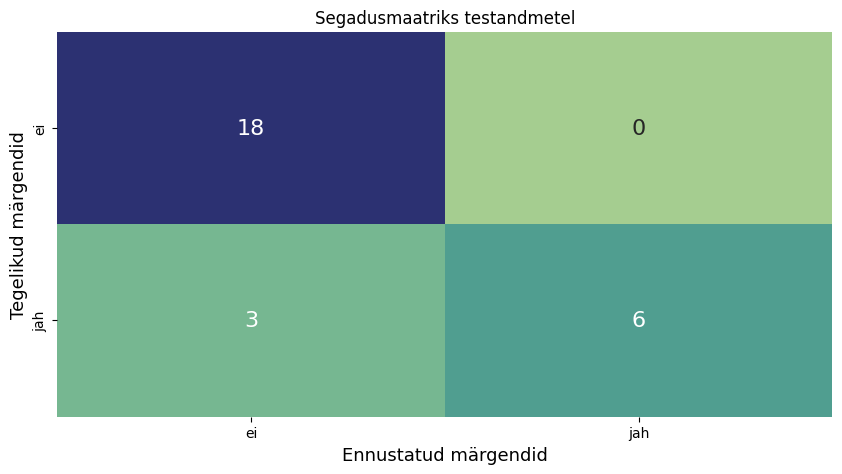

In [44]:
matrix_veider1 = confusion_matrix(y_test, predictions_veider_test)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_veider1 = sns.heatmap(matrix_veider1, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_veider1.set_ylabel("Tegelikud märgendid", fontsize=13);
s_veider1.set_xlabel("Ennustatud märgendid", fontsize=13);
s_veider1.set_title("Segadusmaatriks testandmetel");

In [45]:
c_values = [0.01, 0.03, 0.05, 0.07, 0.1, 0.5, 1, 3, 5, 10, 25, 50, 100]
model_accuracy_test = {}
fscores = {}

for c_value in c_values:
    model = LogisticRegression(C = c_value)
    model.fit(X_train, y_train)
    
    accuracy = model.score(X_test, y_test)
    model_accuracy_test[f"c-value {c_value}"] = accuracy
    
    prediction_test = model.predict(X_test)
    prfs = precision_recall_fscore_support(y_test, prediction_test, average='weighted', zero_division = np.nan)
    fscores[f"c-value {c_value}"] = prfs[2]

In [46]:
print("Mudeli täpsused erinevate C-väärtustega:")
for key, value in model_accuracy_test.items():
    print(key, value)

Mudeli täpsused erinevate C-väärtustega:
c-value 0.01 0.6666666666666666
c-value 0.03 0.6666666666666666
c-value 0.05 0.6666666666666666
c-value 0.07 0.7037037037037037
c-value 0.1 0.7037037037037037
c-value 0.5 0.8148148148148148
c-value 1 0.8888888888888888
c-value 3 0.8888888888888888
c-value 5 0.8888888888888888
c-value 10 0.8888888888888888
c-value 25 0.8888888888888888
c-value 50 0.9259259259259259
c-value 100 0.9259259259259259


In [47]:
print("Mudeli F-skoorid erinevate C-väärtustega:")
for key, value in fscores.items():
    print(key, value)

Mudeli F-skoorid erinevate C-väärtustega:
c-value 0.01 0.8
c-value 0.03 0.8
c-value 0.05 0.8
c-value 0.07 0.6121212121212122
c-value 0.1 0.6121212121212122
c-value 0.5 0.7904940587867417
c-value 1 0.8820512820512819
c-value 3 0.8871224165341813
c-value 5 0.8871224165341813
c-value 10 0.8871224165341813
c-value 25 0.8871224165341813
c-value 50 0.9232456140350878
c-value 100 0.9232456140350878


Mudeli F-skoori väärtuste alusel on otsustatud valida hüperparameetri C väärtuseks 10. Alates C-väärtusest 50 on küll täheldatav F-skoori edasine suurenemine, kuid soov on siiski hoida regularisatsiooni piisavalt kõrgel, et saada hiljem testandmestikul paremaid tulemusi kui treeningandmetel.

In [48]:
model_veider2 = LogisticRegression(C = 10)
model_veider2.fit(X_train, y_train)

LogisticRegression(C=10)

Edaspidi on hindamismeetrikaid kuvatud valideerimisandmestikul.

In [52]:
predictions_veider_val1 = model_veider2.predict(X_val)

In [53]:
classification_report_val_1 = classification_report(y_val, predictions_veider_val1)
print(classification_report_val_1)

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.78      0.70      0.74        10

    accuracy                           0.81        27
   macro avg       0.81      0.79      0.80        27
weighted avg       0.81      0.81      0.81        27



In [54]:
classification_report_val_1 = classification_report(y_val, predictions_veider_val1, output_dict=True)

In [55]:
classification_reports = []

In [56]:
classification_reports.append(classification_report_val_1)

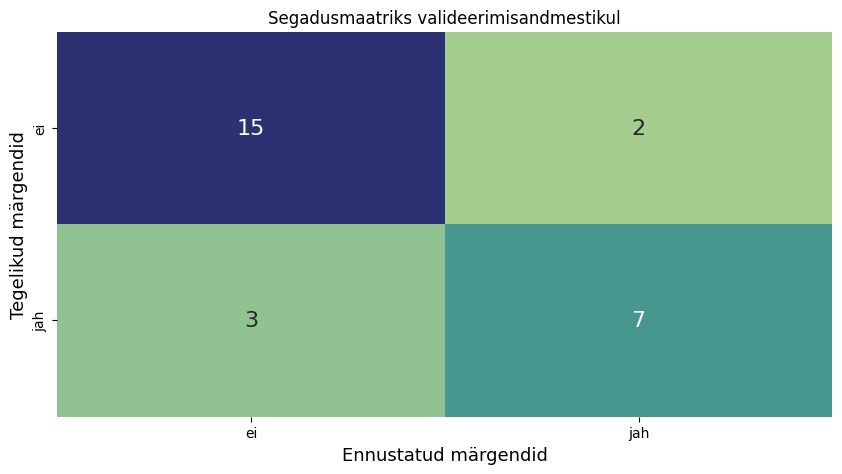

In [57]:
matrix_veider_val1 = confusion_matrix(y_val, predictions_veider_val1)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_veider_val1 = sns.heatmap(matrix_veider_val1, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_veider_val1.set_ylabel("Tegelikud märgendid", fontsize=13);
s_veider_val1.set_xlabel("Ennustatud märgendid", fontsize=13);
s_veider_val1.set_title("Segadusmaatriks valideerimisandmestikul");

In [58]:
fig = s_veider_val1.get_figure()
fig.savefig("val1.png")

In [59]:
labels_veider1 = df_annotated['on_symptom']
features_veider1 = df_to_vec(df_annotated, 'lause')

model_veider1 = LogisticRegression(C=10)
model_veider1.fit(features_veider1, labels_veider1)

LogisticRegression(C=10)

## Ühendus andmebaasiga ning mudeli esimene testimine 150 uue lause peal

In [61]:
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [62]:
conn = psycopg2.connect(database = os.getenv("DATABASE"), 
                        user = os.getenv("USER"), 
                        host= os.getenv("HOST"),
                        password = os.getenv("PASSWORD"),
                        port = os.getenv("PORT"))

In [63]:
cur = conn.cursor()

# Execute a query
cur.execute("SELECT lause FROM user_kristel.esmase_prodroomi_laused WHERE NOT lower(lause::text) SIMILAR TO '%(veider|veidr|veid)%' LIMIT 150;")

# Retrieve query results
records = cur.fetchall()

In [64]:
conn.commit()
conn.close()

In [65]:
df_db_test = pd.DataFrame(records)

In [66]:
lausete_vektorid_db_test = df_to_vec(df_db_test, 0)

In [67]:
predictions_db_test = model_veider1.predict(lausete_vektorid_db_test)
predictions_proba_db_test = model_veider1.predict_proba(lausete_vektorid_db_test)

In [69]:
df_db_test['on_symptom_proba'] = predictions_proba_db_test[:,1]

In [71]:
vähimad_db_test = df_db_test.sort_values(by=['on_symptom_proba'])[:70]

In [72]:
suurimad_db_test = df_db_test.sort_values(by=['on_symptom_proba'])[-70:]

In [50]:
suurimad_db_test.to_excel('suurimad_db_test.xlsx')

Mudel keskendub rohkem mõttekäigule, luululisusele ning meelepettelistele elamustele. Otsustatud hinnata annotatsioone uuesti ning hinnata sümptomiks kõik ainult veidrat käitumist kirjeldavad laused ning jätta välja näiteks veidra mõtlemisega seotud kirjeldused.

In [74]:
df_annotated_uus = pd.read_excel('data2_2.xlsx', index_col=0)

In [75]:
df_annotated_uus.groupby("on_symptom").size()

on_symptom
0    142
1     35
dtype: int64

In [76]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_uus)

In [77]:
print(f"Alganmestiku suurus: {len(df_annotated_uus)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 177
Treeningandmestiku suurus: 123
Testandmestiku suurus: 27
Valideerimisandmestiku suurus: 27


In [78]:
model_veider2 = LogisticRegression(C=10)
model_veider2.fit(X_train, y_train)

LogisticRegression(C=10)

In [82]:
predictions_val_veider2 = model_veider2.predict(X_val)
pred_proba_val_veider2 = model_veider2.predict_proba(X_val)

In [83]:
classification_report_val_veider2 = classification_report(y_val, predictions_val_veider2)
print(classification_report_val_veider2)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.80      0.67      0.73         6

    accuracy                           0.89        27
   macro avg       0.85      0.81      0.83        27
weighted avg       0.88      0.89      0.89        27



In [84]:
classification_report_val_veider2 = classification_report(y_val, predictions_val_veider2, output_dict=True)

In [85]:
classification_reports.append(classification_report_val_veider2)

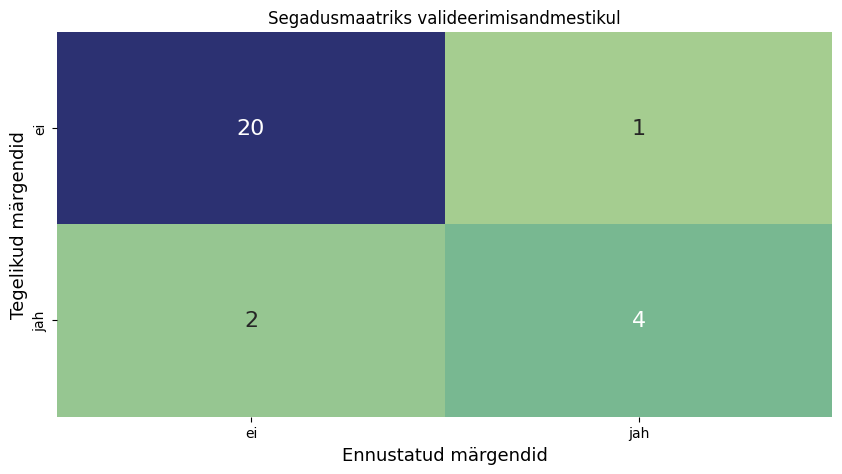

In [86]:
matrix_veider_val2 = confusion_matrix(y_val, predictions_val_veider2)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_veider2 = sns.heatmap(matrix_veider_val2, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_veider2.set_ylabel("Tegelikud märgendid", fontsize=13);
s_veider2.set_xlabel("Ennustatud märgendid", fontsize=13);
s_veider2.set_title("Segadusmaatriks valideerimisandmestikul");

In [87]:
fig = s_veider2.get_figure()
fig.savefig("val_1.png")

In [88]:
labels_veider2 = df_annotated_uus['on_symptom']
features_veider2 = df_to_vec(df_annotated_uus, 'lause')

model_veider2 = LogisticRegression(C=10)
model_veider2.fit(features_veider2, labels_veider2)

LogisticRegression(C=10)

In [90]:
predictions_db_test_uus = model_veider2.predict(lausete_vektorid_db_test)
predictions_proba_test_uus = model_veider2.predict_proba(lausete_vektorid_db_test)

In [92]:
df_db_test['on_symptom_proba_uus'] = predictions_proba_test_uus[:,1]

In [93]:
vähimad_db_test_uus = df_db_test.sort_values(by=['on_symptom_proba_uus'])[:40]

In [94]:
suurimad_db_test_uus = df_db_test.sort_values(by=['on_symptom_proba_uus'])[-40:]

In [95]:
suurimad_db_test_uus.to_excel('suurimad_db_test_uus.xlsx')

### Andmebaasist lausete pärimine ja dataframe´i loomine

In [99]:
conn = psycopg2.connect(database = os.getenv("DATABASE"), 
                        user = os.getenv("USER"), 
                        host= os.getenv("HOST"),
                        password = os.getenv("PASSWORD"),
                        port = os.getenv("PORT"))

In [100]:
cur = conn.cursor()

# Execute a query
cur.execute("SELECT id, tekst_id, lause FROM user_kristel.esmase_prodroomi_laused WHERE NOT lower(lause::text) SIMILAR TO '%(veider|veidr|veid)%';")

# Retrieve query results
records = cur.fetchall()

In [101]:
conn.commit()
conn.close()

In [103]:
df_db_all = pd.DataFrame(records)

In [105]:
df_db_all['puhastatud'] = df_db_all[2].apply(puhasta)
df_db_all['puhastatud'] = df_db_all['puhastatud'].apply(lambda x: x.lower())
df_db_all.drop_duplicates(inplace=True, subset=['puhastatud'])
df_db_all = df_db_all.drop('puhastatud', axis=1)

### Esimene kord 150 suurema tõenäosusega lauset

In [106]:
top_300_1 = df_to_pred(df_db_all, 'data2_2.xlsx', 'db_all_suurimad_300_1.xlsx', model_veider2)

Algselt andmebaasi lausetes:  20197
Pärast andmebaasi lausetes:  20197


## Uute lisa-annotatsioonidega mudeli treenimine vol.1

In [109]:
df_annotated_1 = pd.read_excel('data3_3.xlsx', index_col=0)

In [110]:
df_annotated_1.groupby("on_symptom").size()

on_symptom
0    422
1     55
dtype: int64

In [111]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_1)

In [112]:
print(f"Alganmestiku suurus: {len(df_annotated_1)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 477
Treeningandmestiku suurus: 333
Testandmestiku suurus: 72
Valideerimisandmestiku suurus: 72


In [113]:
model_veider3 = LogisticRegression(C=10)
model_veider3.fit(X_train, y_train)

LogisticRegression(C=10)

In [115]:
predictions_val_veider3 = model_veider3.predict(X_val)

In [116]:
classification_report_val_veider3 = classification_report(y_val, predictions_val_veider3)
print(classification_report_val_veider3)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        63
           1       0.44      0.44      0.44         9

    accuracy                           0.86        72
   macro avg       0.68      0.68      0.68        72
weighted avg       0.86      0.86      0.86        72



In [117]:
classification_report_val_veider3 = classification_report(y_val, predictions_val_veider3, output_dict=True)

In [118]:
classification_reports.append(classification_report_val_veider3)

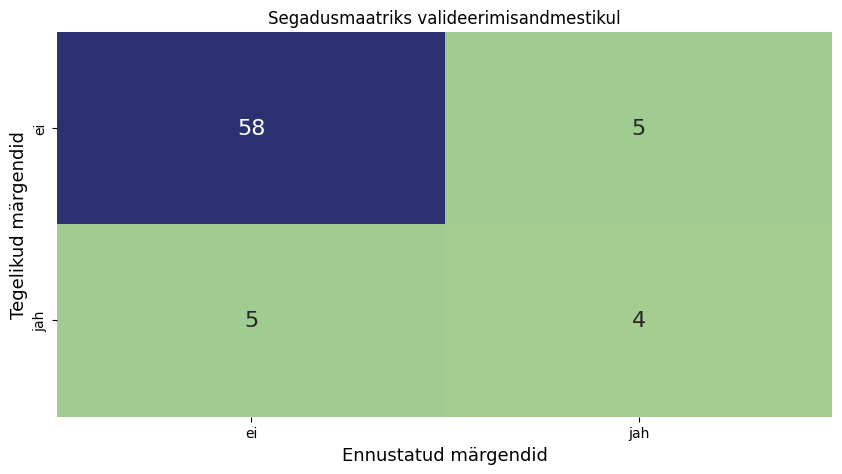

In [119]:
matrix6 = confusion_matrix(y_val, predictions_val_veider3)

fig, axes = plt.subplots(1, figsize=(10, 5))

s6 = sns.heatmap(matrix6, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s6.set_ylabel("Tegelikud märgendid", fontsize=13);
s6.set_xlabel("Ennustatud märgendid", fontsize=13);
s6.set_title("Segadusmaatriks valideerimisandmestikul");

In [120]:
fig = s6.get_figure()
fig.savefig("val_2.png")

In [121]:
labels_veider3 = df_annotated_1['on_symptom']
features_veider3 = df_to_vec(df_annotated_1, 'lause')

model_veider3 = LogisticRegression(C=10)
model_veider3.fit(features_veider3, labels_veider3)

LogisticRegression(C=10)

## Teine kord 150 suurima tõenäosusega lauset andmebaasist

In [123]:
top_300_2 = df_to_pred(df_db_all, 'data3_3.xlsx', 'db_all_suurimad_300_2.xlsx', model_veider3)

Algselt andmebaasi lausetes:  20197
Pärast andmebaasi lausetes:  19897


## Uute lisa-annotatsioonidega mudeli treenimine vol.2

In [125]:
df_annotated_2 = pd.read_excel('data4_3.xlsx', index_col=0)

In [126]:
df_annotated_2.groupby("on_symptom").size()

on_symptom
0    708
1     69
dtype: int64

In [127]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_2)

In [128]:
print(f"Alganmestiku suurus: {len(df_annotated_2)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 777
Treeningandmestiku suurus: 543
Testandmestiku suurus: 117
Valideerimisandmestiku suurus: 117


In [129]:
model_veider4 = LogisticRegression(C=10)
model_veider4.fit(X_train, y_train)

LogisticRegression(C=10)

In [131]:
predictions_val_veider4 = model_veider4.predict(X_val)

In [132]:
classification_report_val_veider4 = classification_report(y_val, predictions_val_veider4)
print(classification_report_val_veider4)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       106
           1       0.20      0.09      0.13        11

    accuracy                           0.88       117
   macro avg       0.56      0.53      0.53       117
weighted avg       0.84      0.88      0.86       117



In [133]:
classification_report_val_veider4 = classification_report(y_val, predictions_val_veider4, output_dict=True)

In [134]:
classification_reports.append(classification_report_val_veider4)

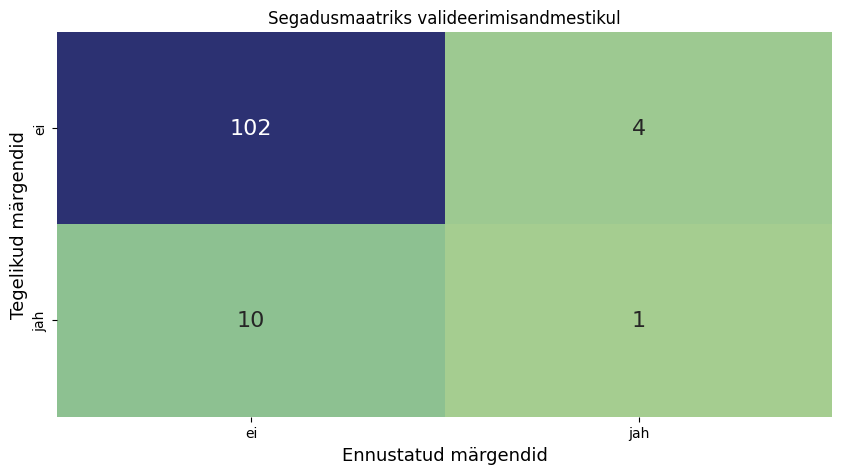

In [135]:
matrix8 = confusion_matrix(y_val, predictions_val_veider4)

fig, axes = plt.subplots(1, figsize=(10, 5))

s8 = sns.heatmap(matrix8, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s8.set_ylabel("Tegelikud märgendid", fontsize=13);
s8.set_xlabel("Ennustatud märgendid", fontsize=13);
s8.set_title("Segadusmaatriks valideerimisandmestikul");

In [136]:
fig = s8.get_figure()
fig.savefig("val_3.png")

In [137]:
labels_veider4= df_annotated_2['on_symptom']
features_veider4 = df_to_vec(df_annotated_2, 'lause')

model_veider4 = LogisticRegression(C=10)
model_veider4.fit(features_veider4, labels_veider4)

LogisticRegression(C=10)

## Kolmas kord 150 suurima tõenäosusega lauset andmebaasist

In [139]:
top_300_3 = df_to_pred(df_db_all, 'data4_3.xlsx', 'db_all_suurimad_300_3.xlsx', model_veider4)

Algselt andmebaasi lausetes:  20197
Pärast andmebaasi lausetes:  19597


## Uute lisa-annotatsioonidega mudeli treenimine vol.3

In [192]:
df_annotated_3 = pd.read_excel('data5_3.xlsx', index_col=0)

In [193]:
df_annotated_3.groupby("on_symptom").size()

on_symptom
0    727
1     71
dtype: int64

In [194]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_3)

In [195]:
print(f"Alganmestiku suurus: {len(df_annotated_3)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 798
Treeningandmestiku suurus: 558
Testandmestiku suurus: 120
Valideerimisandmestiku suurus: 120


In [196]:
model_veider5 = LogisticRegression(C=10)
model_veider5.fit(X_train, y_train)

LogisticRegression(C=10)

In [197]:
predictions_val_veider5 = model_veider5.predict(X_val)

In [198]:
classification_report_val_veider5 = classification_report(y_val, predictions_val_veider5)
print(classification_report_val_veider5)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       109
           1       0.00      0.00      0.00        11

    accuracy                           0.87       120
   macro avg       0.45      0.48      0.46       120
weighted avg       0.82      0.87      0.84       120



In [199]:
classification_report_val_veider5 = classification_report(y_val, predictions_val_veider5, output_dict=True)

In [200]:
classification_reports.append(classification_report_val_veider5)

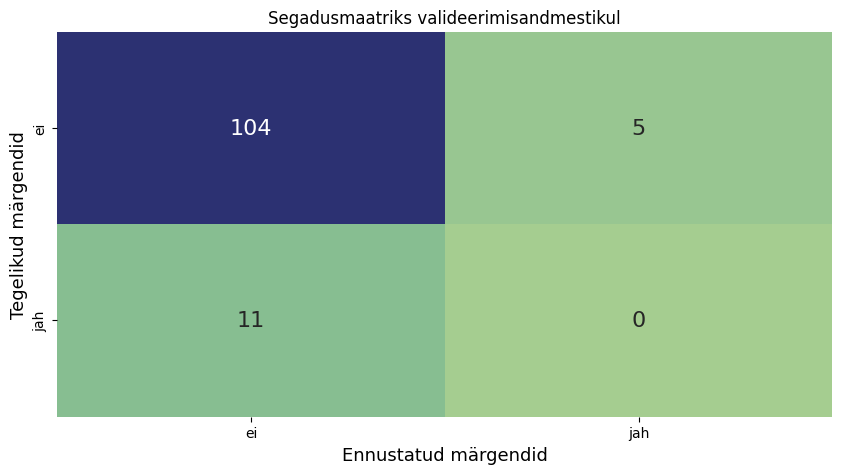

In [201]:
matrix9 = confusion_matrix(y_val, predictions_val_veider5)

fig, axes = plt.subplots(1, figsize=(10, 5))

s9 = sns.heatmap(matrix9, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s9.set_ylabel("Tegelikud märgendid", fontsize=13);
s9.set_xlabel("Ennustatud märgendid", fontsize=13);
s9.set_title("Segadusmaatriks valideerimisandmestikul");

In [202]:
fig = s9.get_figure()
fig.savefig("val_4.png")

In [203]:
labels_veider5 = df_annotated_3['on_symptom']
features_veider5 = df_to_vec(df_annotated_3, 'lause')

model_veider5 = LogisticRegression(C=10)
model_veider5.fit(features_veider5, labels_veider5)

LogisticRegression(C=10)

## Neljas kord 150 suurima tõenäosusega lauset andmebaasist

In [204]:
top_300_4 = df_to_pred(df_db_all, 'data5_3.xlsx', 'db_all_suurimad_300_4.xlsx', model_veider5)

Algselt andmebaasi lausetes:  20197
Pärast andmebaasi lausetes:  19576


In [205]:
df_annotated_4 = pd.read_excel('data6_3.xlsx', index_col=0)

In [207]:
df_annotated_4.groupby("on_symptom").size()

on_symptom
0    728
1     71
dtype: int64

In [208]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_4)

In [209]:
print(f"Alganmestiku suurus: {len(df_annotated_4)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 799
Treeningandmestiku suurus: 559
Testandmestiku suurus: 120
Valideerimisandmestiku suurus: 120


In [210]:
model_veider6 = LogisticRegression(C=10)
model_veider6.fit(X_train, y_train)

LogisticRegression(C=10)

In [211]:
predictions_val_veider6 = model_veider6.predict(X_val)

In [212]:
classification_report_val_veider6 = classification_report(y_val, predictions_val_veider6)
print(classification_report_val_veider6)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       109
           1       0.00      0.00      0.00        11

    accuracy                           0.86       120
   macro avg       0.45      0.47      0.46       120
weighted avg       0.82      0.86      0.84       120



In [213]:
classification_report_val_veider6 = classification_report(y_val, predictions_val_veider6, output_dict=True)

In [214]:
classification_reports.append(classification_report_val_veider6)

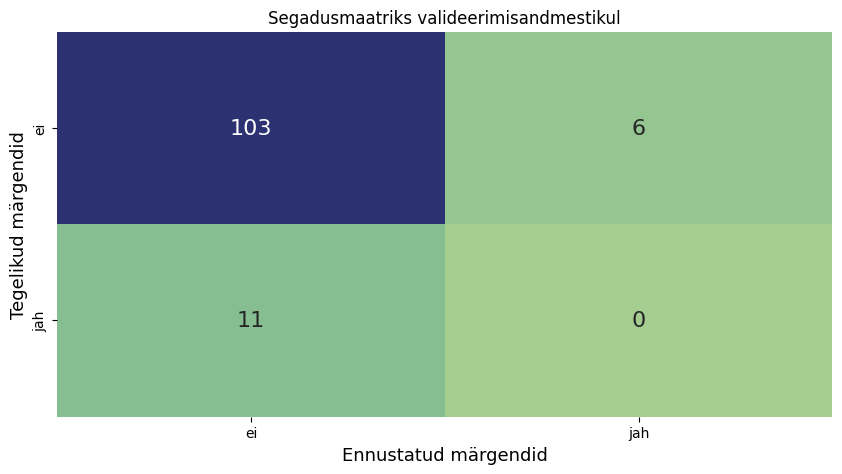

In [215]:
matrix10 = confusion_matrix(y_val, predictions_val_veider6)

fig, axes = plt.subplots(1, figsize=(10, 5))

s10 = sns.heatmap(matrix10, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s10.set_ylabel("Tegelikud märgendid", fontsize=13);
s10.set_xlabel("Ennustatud märgendid", fontsize=13);
s10.set_title("Segadusmaatriks valideerimisandmestikul");

In [216]:
fig = s10.get_figure()
fig.savefig("val_5.png")

In [217]:
labels_veider6 = df_annotated_4['on_symptom']
features_veider6 = df_to_vec(df_annotated_4, 'lause')

model_veider6 = LogisticRegression(C=10)
model_veider6.fit(features_veider6, labels_veider6)

LogisticRegression(C=10)

In [218]:
top_300_5 = df_to_pred(df_db_all, 'data6_3.xlsx', 'db_all_suurimad_300_5.xlsx', model_veider6)

Algselt andmebaasi lausetes:  20197
Pärast andmebaasi lausetes:  19575


Siinkohal ei ennustanud mudel enam ühtegi lauset > 0.5 tõenäosusega

# Enda etteantud lausega mudeli katsetamine

In [231]:
def sentence_to_pred(lause, model=model_veider6):
    lause_vektor = sentence_to_vecs(lause)
    return model.predict_proba([lause_vektor])

In [235]:
enda_lause = "Esineb veider käitumine."

In [237]:
# Väljastatakse klassi kuulumise tõenäosus; esimesel kohal klass 0 ehk ei ole sümptom ning teisel kohal klass 1 ehk on tõenäoliselt sümptom)
sentence_to_pred(enda_lause)

array([[0.30298614, 0.69701386]])

# Meetodi valideerimine

## II sümptom ("depersonalisatsioon/derealisatsioon")

In [238]:
df_annotated_dereal_deperso1 = pd.read_excel('data_dereal_deperso1.xlsx', index_col=0)

In [239]:
df_annotated_dereal_deperso1.groupby("on_symptom").size()

on_symptom
0    20
1    20
dtype: int64

In [240]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_dereal_deperso1)

In [241]:
print(f"Alganmestiku suurus: {len(df_annotated_dereal_deperso1)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 40
Treeningandmestiku suurus: 28
Testandmestiku suurus: 6
Valideerimisandmestiku suurus: 6


In [242]:
model_dereal_deperso1 = LogisticRegression(C = 10)
model_dereal_deperso1.fit(X_train, y_train)

LogisticRegression(C=10)

In [243]:
predictions_val_dereal_deperso = model_dereal_deperso1.predict(X_val)

In [244]:
classification_report_val_dereal_deperso = classification_report(y_val, predictions_val_dereal_deperso)
print(classification_report_val_dereal_deperso)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



In [245]:
classification_report_val_dereal_deperso = classification_report(y_val, predictions_val_dereal_deperso, output_dict=True)

In [246]:
classification_reports.append(classification_report_val_dereal_deperso)

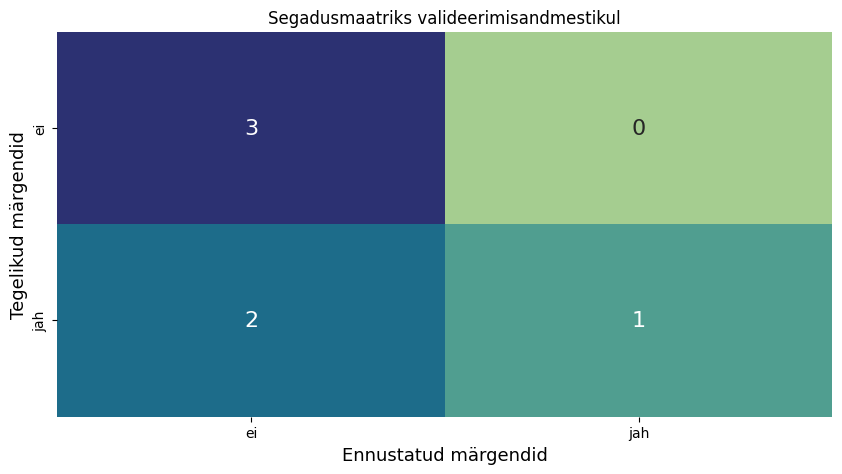

In [247]:
matrix_dereal_deperso_val = confusion_matrix(y_val, predictions_val_dereal_deperso)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_dereal_deperso_val = sns.heatmap(matrix_dereal_deperso_val, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_dereal_deperso_val.set_ylabel("Tegelikud märgendid", fontsize=13);
s_dereal_deperso_val.set_xlabel("Ennustatud märgendid", fontsize=13);
s_dereal_deperso_val.set_title("Segadusmaatriks valideerimisandmestikul");

In [271]:
fig = s_dereal_deperso_val.get_figure()
fig.savefig("val_6.png")

In [248]:
labels_de1 = df_annotated_dereal_deperso1['on_symptom']
features_de1 = df_to_vec(df_annotated_dereal_deperso1, 'lause')

model_dereal_deperso1 = LogisticRegression(C = 10)
model_dereal_deperso1.fit(features_de1, labels_de1)

LogisticRegression(C=10)

### Andmebaasist laused

In [250]:
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [251]:
conn = psycopg2.connect(database = os.getenv("DATABASE"), 
                        user = os.getenv("USER"), 
                        host= os.getenv("HOST"),
                        password = os.getenv("PASSWORD"),
                        port = os.getenv("PORT"))

In [252]:
cur = conn.cursor()

# Execute a query
cur.execute("SELECT id, tekst_id, lause FROM user_kristel.esmase_prodroomi_laused WHERE NOT lower(lause::text) SIMILAR TO '%(dereal|depers|depr)%';")

# Retrieve query results
records = cur.fetchall()

In [253]:
conn.commit()
conn.close()

In [255]:
df_db_all = pd.DataFrame(records)

In [257]:
df_db_all['puhastatud'] = df_db_all[2].apply(puhasta)
df_db_all['puhastatud'] = df_db_all['puhastatud'].apply(lambda x: x.lower())
df_db_all.drop_duplicates(inplace=True, subset=['puhastatud'])
df_db_all = df_db_all.drop('puhastatud', axis=1)

### Iteratsioonid

In [258]:
top_300_dereal_deperso1 = df_to_pred(df_db_all, 'data_dereal_deperso1.xlsx', 'db_all_suurimad_300_dereal_deperso_1.xlsx', model_dereal_deperso1)

Algselt andmebaasi lausetes:  20116
Pärast andmebaasi lausetes:  20114


In [261]:
df_annotated_dereal_deperso2 = pd.read_excel('data_dereal_deperso2.xlsx', index_col=0)

In [262]:
df_annotated_dereal_deperso2.groupby("on_symptom").size()

on_symptom
0    320
1     20
dtype: int64

In [263]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_dereal_deperso2)

In [264]:
print(f"Alganmestiku suurus: {len(df_annotated_dereal_deperso2)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 340
Treeningandmestiku suurus: 238
Testandmestiku suurus: 51
Valideerimisandmestiku suurus: 51


In [265]:
model_dereal_deperso2 = LogisticRegression(C = 10)
model_dereal_deperso2.fit(X_train, y_train)

LogisticRegression(C=10)

In [266]:
predictions_val_dereal_deperso2 = model_dereal_deperso2.predict(X_val)

In [267]:
classification_report_val_dereal_deperso2 = classification_report(y_val, predictions_val_dereal_deperso2, output_dict=True)

In [268]:
classification_reports.append(classification_report_val_dereal_deperso2)

In [269]:
classification_report_val_dereal_deperso2 = classification_report(y_val, predictions_val_dereal_deperso2)
print(classification_report_val_dereal_deperso2)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.00      0.00      0.00         3

    accuracy                           0.90        51
   macro avg       0.47      0.48      0.47        51
weighted avg       0.88      0.90      0.89        51



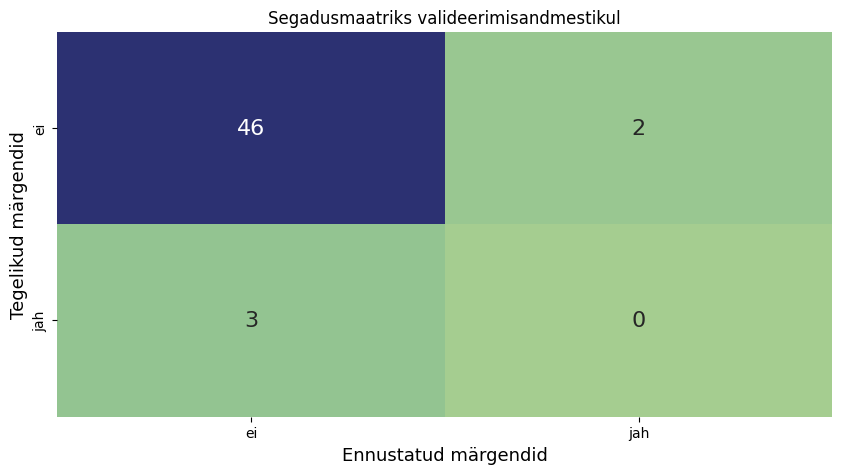

In [270]:
matrix_dereal_deperso_val2 = confusion_matrix(y_val, predictions_val_dereal_deperso2)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_dereal_deperso_val2 = sns.heatmap(matrix_dereal_deperso_val2, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_dereal_deperso_val2.set_ylabel("Tegelikud märgendid", fontsize=13);
s_dereal_deperso_val2.set_xlabel("Ennustatud märgendid", fontsize=13);
s_dereal_deperso_val2.set_title("Segadusmaatriks valideerimisandmestikul");

In [272]:
fig = s_dereal_deperso_val2.get_figure()
fig.savefig("val_7.png")

In [273]:
labels_de2 = df_annotated_dereal_deperso2['on_symptom']
features_de2 = df_to_vec(df_annotated_dereal_deperso2, 'lause')

model_dereal_deperso2 = LogisticRegression(C = 10)
model_dereal_deperso2.fit(features_de2, labels_de2)

LogisticRegression(C=10)

In [275]:
top_300_dereal_deperso2 = df_to_pred(df_db_all, 'data_dereal_deperso2.xlsx', 'db_all_suurimad_300_dereal_deperso_2.xlsx', model_dereal_deperso2)

Algselt andmebaasi lausetes:  20116
Pärast andmebaasi lausetes:  19814


In [277]:
df_annotated_dereal_deperso3 = pd.read_excel('data_dereal_deperso3.xlsx', index_col=0)

In [278]:
df_annotated_dereal_deperso3.groupby("on_symptom").size()

on_symptom
0    616
1     24
dtype: int64

In [279]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_dereal_deperso3)

In [280]:
print(f"Alganmestiku suurus: {len(df_annotated_dereal_deperso3)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 640
Treeningandmestiku suurus: 448
Testandmestiku suurus: 96
Valideerimisandmestiku suurus: 96


In [281]:
model_dereal_deperso3 = LogisticRegression(C = 10)
model_dereal_deperso3.fit(X_train, y_train)

LogisticRegression(C=10)

In [282]:
predictions_val_dereal_deperso3 = model_dereal_deperso3.predict(X_val)

In [283]:
classification_report_val_dereal_deperso3 = classification_report(y_val, predictions_val_dereal_deperso3, output_dict=True)

In [284]:
classification_report_val_dereal_deperso3 = classification_report(y_val, predictions_val_dereal_deperso3)
print(classification_report_val_dereal_deperso3)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        92
           1       0.00      0.00      0.00         4

    accuracy                           0.93        96
   macro avg       0.48      0.48      0.48        96
weighted avg       0.92      0.93      0.92        96



In [285]:
classification_reports.append(classification_report_val_dereal_deperso3)

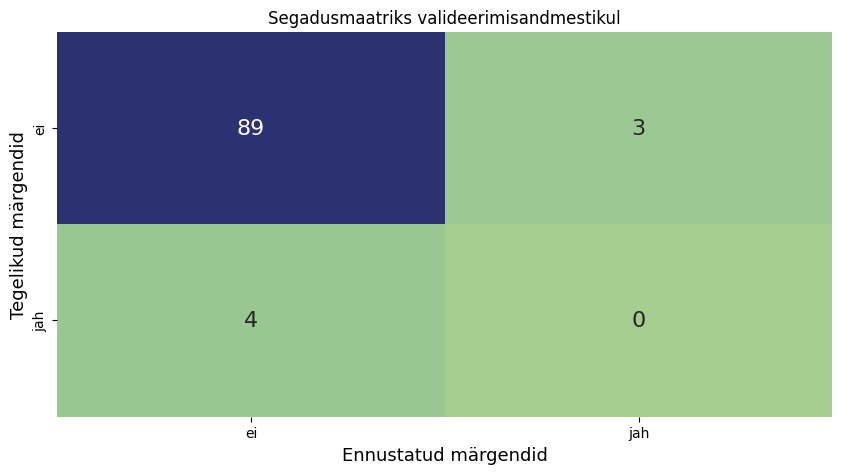

In [286]:
matrix_dereal_deperso_val3 = confusion_matrix(y_val, predictions_val_dereal_deperso3)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_dereal_deperso_val3 = sns.heatmap(matrix_dereal_deperso_val3, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_dereal_deperso_val3.set_ylabel("Tegelikud märgendid", fontsize=13);
s_dereal_deperso_val3.set_xlabel("Ennustatud märgendid", fontsize=13);
s_dereal_deperso_val3.set_title("Segadusmaatriks valideerimisandmestikul");

In [287]:
fig = s_dereal_deperso_val3.get_figure()
fig.savefig("val_8.png")

In [288]:
labels_de3 = df_annotated_dereal_deperso3['on_symptom']
features_de3 = df_to_vec(df_annotated_dereal_deperso3, 'lause')

model_dereal_deperso3 = LogisticRegression(C = 10)
model_dereal_deperso3.fit(features_de3, labels_de3)

LogisticRegression(C=10)

In [290]:
top_300_dereal_deperso3 = df_to_pred(df_db_all, 'data_dereal_deperso3.xlsx', 'db_all_suurimad_300_dereal_deperso_3.xlsx', model_dereal_deperso3)

Algselt andmebaasi lausetes:  20116
Pärast andmebaasi lausetes:  19514


In [292]:
df_annotated_dereal_deperso4 = pd.read_excel('data_dereal_deperso4.xlsx', index_col=0)

In [293]:
df_annotated_dereal_deperso4.groupby("on_symptom").size()

on_symptom
0    619
1     24
dtype: int64

In [294]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_dereal_deperso4)

In [295]:
print(f"Alganmestiku suurus: {len(df_annotated_dereal_deperso4)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 643
Treeningandmestiku suurus: 450
Testandmestiku suurus: 97
Valideerimisandmestiku suurus: 96


In [296]:
model_dereal_deperso4 = LogisticRegression(C = 10)
model_dereal_deperso4.fit(X_train, y_train)

LogisticRegression(C=10)

In [297]:
predictions_val_dereal_deperso4 = model_dereal_deperso4.predict(X_val)

In [298]:
classification_report_val_dereal_deperso4 = classification_report(y_val, predictions_val_dereal_deperso4)
print(classification_report_val_dereal_deperso4)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        93
           1       0.00      0.00      0.00         3

    accuracy                           0.96        96
   macro avg       0.48      0.49      0.49        96
weighted avg       0.94      0.96      0.95        96



In [299]:
classification_report_val_dereal_deperso4 = classification_report(y_val, predictions_val_dereal_deperso4, output_dict=True)

In [300]:
classification_reports.append(classification_report_val_dereal_deperso4)

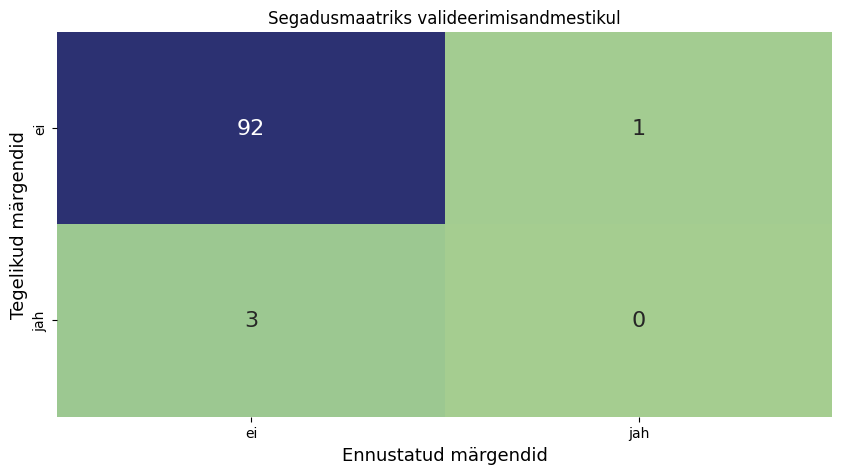

In [301]:
matrix_dereal_deperso_val4 = confusion_matrix(y_val, predictions_val_dereal_deperso4)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_dereal_deperso_val4 = sns.heatmap(matrix_dereal_deperso_val4, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_dereal_deperso_val4.set_ylabel("Tegelikud märgendid", fontsize=13);
s_dereal_deperso_val4.set_xlabel("Ennustatud märgendid", fontsize=13);
s_dereal_deperso_val4.set_title("Segadusmaatriks valideerimisandmestikul");

In [302]:
fig = s_dereal_deperso_val4.get_figure()
fig.savefig("val_9.png")

In [303]:
labels_de4 = df_annotated_dereal_deperso4['on_symptom']
features_de4 = df_to_vec(df_annotated_dereal_deperso4, 'lause')

model_dereal_deperso4 = LogisticRegression(C = 10)
model_dereal_deperso4.fit(features_de4, labels_de4)

LogisticRegression(C=10)

In [305]:
top_300_dereal_deperso4 = df_to_pred(df_db_all, 'data_dereal_deperso4.xlsx', 'db_all_suurimad_300_dereal_deperso_4.xlsx', model_dereal_deperso4)

Algselt andmebaasi lausetes:  20116
Pärast andmebaasi lausetes:  19511


Mudel ei ennusta enam meile otsitavaid lauseid, lõpetame iteratsioonid.

## III sümptom ("paranoiline luulumõte/kahtlustamine")

In [307]:
df_annotated_p = pd.read_excel('data_paranoia.xlsx', index_col=0)

In [308]:
df_annotated_p.groupby("on_symptom").size()

on_symptom
0    158
1    105
dtype: int64

In [309]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_p)

In [310]:
print(f"Alganmestiku suurus: {len(df_annotated_p)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 263
Treeningandmestiku suurus: 184
Testandmestiku suurus: 40
Valideerimisandmestiku suurus: 39


In [311]:
model_p1 = LogisticRegression(C = 10)
model_p1.fit(X_train, y_train)

LogisticRegression(C=10)

In [312]:
predictions_val_p = model_p1.predict(X_val)

In [313]:
classification_report_val_p = classification_report(y_val, predictions_val_p)
print(classification_report_val_p)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.87      0.81      0.84        16

    accuracy                           0.87        39
   macro avg       0.87      0.86      0.87        39
weighted avg       0.87      0.87      0.87        39



In [314]:
classification_report_val_p = classification_report(y_val, predictions_val_p, output_dict=True)

In [315]:
classification_reports.append(classification_report_val_p)

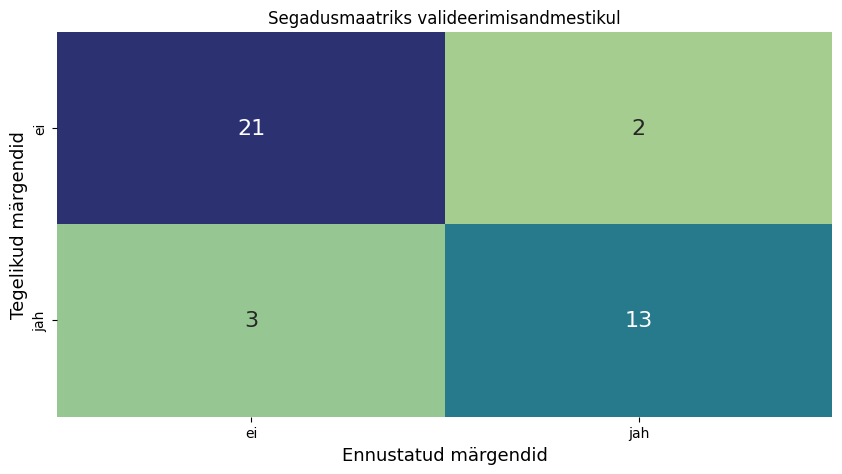

In [316]:
matrix_p_val = confusion_matrix(y_val, predictions_val_p)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_p_val = sns.heatmap(matrix_p_val, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_p_val.set_ylabel("Tegelikud märgendid", fontsize=13);
s_p_val.set_xlabel("Ennustatud märgendid", fontsize=13);
s_p_val.set_title("Segadusmaatriks valideerimisandmestikul");

In [317]:
fig = s_p_val.get_figure()
fig.savefig("val_10.png")

In [318]:
labels_p1 = df_annotated_p['on_symptom']
features_p1 = df_to_vec(df_annotated_p, 'lause')

model_p1 = LogisticRegression(C = 10)
model_p1.fit(features_p1, labels_p1)

LogisticRegression(C=10)

### Andmebaasist laused

In [320]:
conn = psycopg2.connect(database = os.getenv("DATABASE"), 
                        user = os.getenv("USER"), 
                        host= os.getenv("HOST"),
                        password = os.getenv("PASSWORD"),
                        port = os.getenv("PORT"))

In [321]:
cur = conn.cursor()

# Execute a query
cur.execute("SELECT id, tekst_id, lause FROM user_kristel.esmase_prodroomi_laused;")

# Retrieve query results
records = cur.fetchall()

In [322]:
conn.commit()
conn.close()

In [324]:
df_db_all_para = pd.DataFrame(records)

In [326]:
df_db_all_para['puhastatud'] = df_db_all_para[2].apply(puhasta)
df_db_all_para['puhastatud'] = df_db_all_para['puhastatud'].apply(lambda x: x.lower())
df_db_all_para.drop_duplicates(inplace=True, subset=['puhastatud'])
df_db_all_para = df_db_all_para.drop('puhastatud', axis=1)

### Iteratsioonid

In [327]:
top_300_p1 = df_to_pred(df_db_all_para, 'data_paranoia.xlsx', 'db_all_suurimad_300_p_1.xlsx', model_p1)

Algselt andmebaasi lausetes:  20383
Pärast andmebaasi lausetes:  20128


In [329]:
df_annotated_p2 = pd.read_excel('data_paranoia2.xlsx', index_col=0)

In [330]:
df_annotated_p2.groupby("on_symptom").size()

on_symptom
0    424
1    139
dtype: int64

In [331]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_p2)

In [332]:
print(f"Alganmestiku suurus: {len(df_annotated_p2)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 563
Treeningandmestiku suurus: 394
Testandmestiku suurus: 85
Valideerimisandmestiku suurus: 84


In [333]:
model_p2 = LogisticRegression(C = 10)
model_p2.fit(X_train, y_train)

LogisticRegression(C=10)

In [334]:
predictions_val_p2 = model_p2.predict(X_val)

In [335]:
classification_report_val_p2 = classification_report(y_val, predictions_val_p2)
print(classification_report_val_p2)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        63
           1       0.55      0.52      0.54        21

    accuracy                           0.77        84
   macro avg       0.70      0.69      0.69        84
weighted avg       0.77      0.77      0.77        84



In [336]:
classification_report_val_p2 = classification_report(y_val, predictions_val_p2, output_dict=True)

In [337]:
classification_reports.append(classification_report_val_p2)

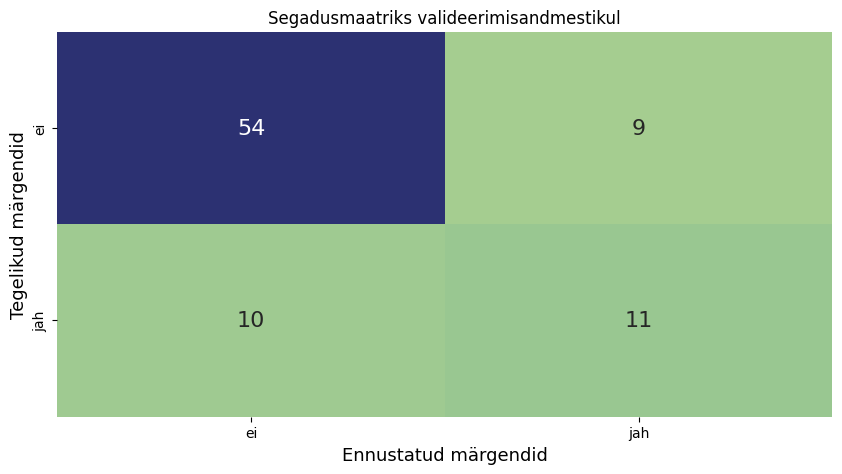

In [338]:
matrix_p_val2 = confusion_matrix(y_val, predictions_val_p2)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_p_val2 = sns.heatmap(matrix_p_val2, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_p_val2.set_ylabel("Tegelikud märgendid", fontsize=13);
s_p_val2.set_xlabel("Ennustatud märgendid", fontsize=13);
s_p_val2.set_title("Segadusmaatriks valideerimisandmestikul");

In [339]:
fig = s_p_val2.get_figure()
fig.savefig("val_11.png")

In [342]:
labels_p2 = df_annotated_p2['on_symptom']
features_p2 = df_to_vec(df_annotated_p2, 'lause')

model_p2 = LogisticRegression(C = 10, max_iter=1000)
model_p2.fit(features_p2, labels_p2)

LogisticRegression(C=10, max_iter=1000)

max_iter väärtust suurendatud veateate tõttu

In [344]:
top_300_p2 = df_to_pred(df_db_all_para, 'data_paranoia2.xlsx', 'db_all_suurimad_300_p_2.xlsx', model_p2)

Algselt andmebaasi lausetes:  20383
Pärast andmebaasi lausetes:  19828


In [346]:
df_annotated_p3 = pd.read_excel('data_paranoia3.xlsx', index_col=0)

In [347]:
df_annotated_p3.groupby("on_symptom").size()

on_symptom
0    717
1    146
dtype: int64

In [348]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_p3)

In [349]:
print(f"Alganmestiku suurus: {len(df_annotated_p3)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 863
Treeningandmestiku suurus: 604
Testandmestiku suurus: 130
Valideerimisandmestiku suurus: 129


In [350]:
model_p3 = LogisticRegression(C = 10)
model_p3.fit(X_train, y_train)

LogisticRegression(C=10)

In [351]:
predictions_val_p3 = model_p3.predict(X_val)

In [352]:
classification_report_val_p3 = classification_report(y_val, predictions_val_p3)
print(classification_report_val_p3)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       107
           1       0.19      0.14      0.16        22

    accuracy                           0.75       129
   macro avg       0.51      0.51      0.51       129
weighted avg       0.72      0.75      0.74       129



In [353]:
classification_report_val_p3 = classification_report(y_val, predictions_val_p3, output_dict=True)

In [354]:
classification_reports.append(classification_report_val_p3)

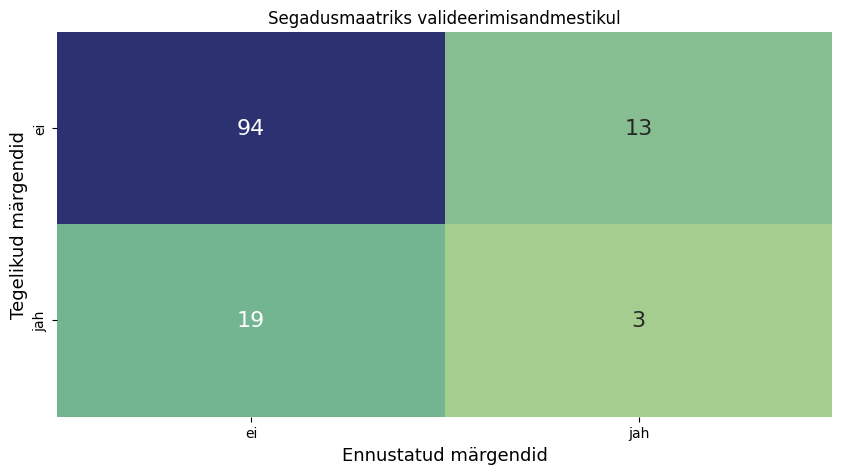

In [355]:
matrix_p_val3 = confusion_matrix(y_val, predictions_val_p3)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_p_val3 = sns.heatmap(matrix_p_val3, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_p_val3.set_ylabel("Tegelikud märgendid", fontsize=13);
s_p_val3.set_xlabel("Ennustatud märgendid", fontsize=13);
s_p_val3.set_title("Segadusmaatriks valideerimisandmestikul");

In [356]:
fig = s_p_val3.get_figure()
fig.savefig("val_12.png")

In [357]:
labels_p3 = df_annotated_p3['on_symptom']
features_p3 = df_to_vec(df_annotated_p3, 'lause')

model_p3 = LogisticRegression(C = 10, max_iter=1000)
model_p3.fit(features_p3, labels_p3)

LogisticRegression(C=10, max_iter=1000)

In [359]:
top_300_p3 = df_to_pred(df_db_all_para, 'data_paranoia3.xlsx', 'db_all_suurimad_300_p_3.xlsx', model_p3)

Algselt andmebaasi lausetes:  20383
Pärast andmebaasi lausetes:  19528


In [361]:
df_annotated_p4 = pd.read_excel('data_paranoia4.xlsx', index_col=0)

In [362]:
df_annotated_p4.groupby("on_symptom").size()

on_symptom
0    958
1    205
dtype: int64

In [363]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_p4)

In [364]:
print(f"Alganmestiku suurus: {len(df_annotated_p4)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 1163
Treeningandmestiku suurus: 814
Testandmestiku suurus: 175
Valideerimisandmestiku suurus: 174


In [365]:
model_p4 = LogisticRegression(C = 10)
model_p4.fit(X_train, y_train)

LogisticRegression(C=10)

In [366]:
predictions_val_p4 = model_p4.predict(X_val)

In [367]:
classification_report_val_p4 = classification_report(y_val, predictions_val_p4)
print(classification_report_val_p4)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       143
           1       0.35      0.29      0.32        31

    accuracy                           0.78       174
   macro avg       0.60      0.59      0.59       174
weighted avg       0.76      0.78      0.77       174



In [368]:
classification_report_val_p4 = classification_report(y_val, predictions_val_p4, output_dict=True)

In [369]:
classification_reports.append(classification_report_val_p4)

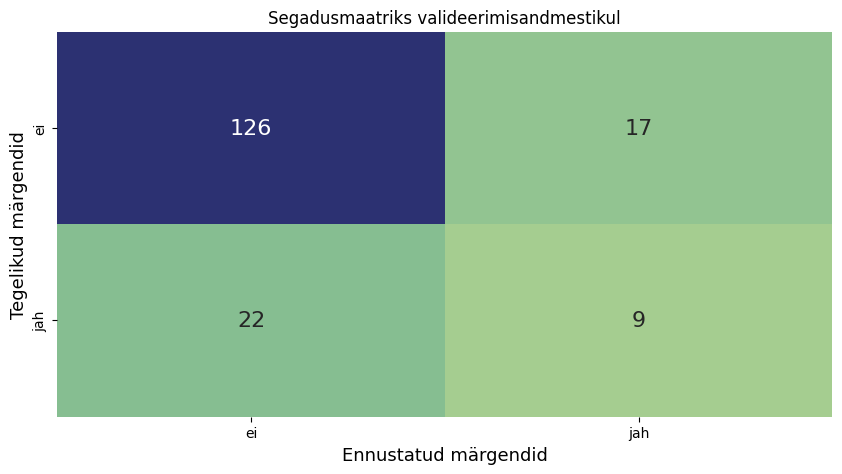

In [370]:
matrix_p_val4 = confusion_matrix(y_val, predictions_val_p4)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_p_val4 = sns.heatmap(matrix_p_val4, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_p_val4.set_ylabel("Tegelikud märgendid", fontsize=13);
s_p_val4.set_xlabel("Ennustatud märgendid", fontsize=13);
s_p_val4.set_title("Segadusmaatriks valideerimisandmestikul");

In [371]:
fig = s_p_val4.get_figure()
fig.savefig("val_13.png")

In [372]:
labels_p4 = df_annotated_p4['on_symptom']
features_p4 = df_to_vec(df_annotated_p4, 'lause')

model_p4 = LogisticRegression(C = 10)
model_p4.fit(features_p4, labels_p4)

LogisticRegression(C=10)

In [374]:
top_300_p4 = df_to_pred(df_db_all_para, 'data_paranoia4.xlsx', 'db_all_suurimad_300_p_4.xlsx', model_p4)

Algselt andmebaasi lausetes:  20383
Pärast andmebaasi lausetes:  19228


In [376]:
df_annotated_p5 = pd.read_excel('data_paranoia5.xlsx', index_col=0)

In [377]:
df_annotated_p5.groupby("on_symptom").size()

on_symptom
0    970
1    205
dtype: int64

In [378]:
X_train, y_train, X_test, y_test, X_val, y_val = df_to_train_data(df_annotated_p5)

In [379]:
print(f"Alganmestiku suurus: {len(df_annotated_p5)}")
print(f"Treeningandmestiku suurus: {len(X_train)}")
print(f"Testandmestiku suurus: {len(X_test)}")
print(f"Valideerimisandmestiku suurus: {len(X_val)}")

Alganmestiku suurus: 1175
Treeningandmestiku suurus: 822
Testandmestiku suurus: 177
Valideerimisandmestiku suurus: 176


In [380]:
model_p5 = LogisticRegression(C = 10)
model_p5.fit(X_train, y_train)

LogisticRegression(C=10)

In [381]:
predictions_val_p5 = model_p5.predict(X_val)

In [382]:
classification_report_val_p5 = classification_report(y_val, predictions_val_p5)
print(classification_report_val_p5)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.20      0.13      0.16        31

    accuracy                           0.76       176
   macro avg       0.51      0.51      0.51       176
weighted avg       0.72      0.76      0.73       176



In [383]:
classification_report_val_p5 = classification_report(y_val, predictions_val_p5, output_dict=True)

In [384]:
classification_reports.append(classification_report_val_p5)

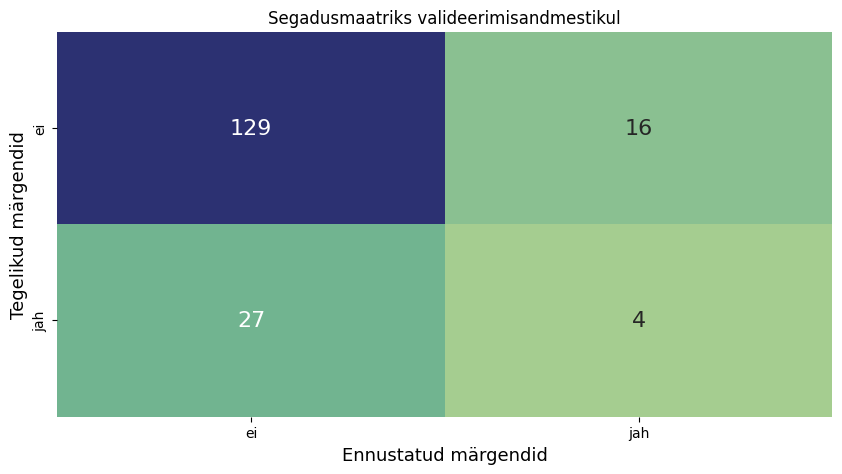

In [385]:
matrix_p_val5 = confusion_matrix(y_val, predictions_val_p5)

fig, axes = plt.subplots(1, figsize=(10, 5))

s_p_val5 = sns.heatmap(matrix_p_val5, cmap='crest', annot=True, annot_kws={"fontsize":16}, cbar=False, fmt="d", xticklabels=["ei", "jah"], yticklabels=["ei", "jah"]);
s_p_val5.set_ylabel("Tegelikud märgendid", fontsize=13);
s_p_val5.set_xlabel("Ennustatud märgendid", fontsize=13);
s_p_val5.set_title("Segadusmaatriks valideerimisandmestikul");

In [386]:
fig = s_p_val5.get_figure()
fig.savefig("val_14.png")

In [387]:
labels_p5 = df_annotated_p5['on_symptom']
features_p5 = df_to_vec(df_annotated_p5, 'lause')

model_p5 = LogisticRegression(C = 10)
model_p5.fit(features_p5, labels_p5)

LogisticRegression(C=10)

In [389]:
top_300_p5 = df_to_pred(df_db_all_para, 'data_paranoia5.xlsx', 'db_all_suurimad_300_p_5.xlsx', model_p5)

Algselt andmebaasi lausetes:  20383
Pärast andmebaasi lausetes:  19216


Siinkohal mudel ennustab ebakindlalt. Iteratsioonid lõpetatud.

# Word2Vec mudelist puuduvad sõnad

In [391]:
vasteta_sõnad_final = sorted(vasteta_count.items(), key=lambda x:x[1])

In [394]:
vasteta_sõnu_kokku = 0

for key, value in vasteta_sõnad_final:
    vasteta_sõnu_kokku += 1

In [395]:
print(f"Vasteta sõnu kokku: {vasteta_sõnu_kokku}")

Vasteta sõnu kokku: 8368


In [397]:
data = []

for key, value in vasteta_sõnad_final:
    data.append([key, value])

In [398]:
df_puuduvad_sõnad = pd.DataFrame(data, columns=['sõna', 'sagedus'])

In [399]:
df_puuduvad_sõnad.to_excel('puuduvad_sõnad.xlsx')